In [1]:
import os
import numpy as np#use <2

import cv2 
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
from tensorflow.keras.utils import load_img
from tensorflow.keras.preprocessing import image
import tensorflow.keras.layers as tensor

import keras
from keras.utils import image_dataset_from_directory 

print(tf.__version__)
#this notebook works on both keras v2 and v3 
print(keras.__version__)

2.10.1
2.10.0


In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Loading the Data


In [3]:
#image_directory="ARB_sensor/seperated_heatmap_data/"#specify the image directory
image_directory="HAR_datasets/HAR_research_99_acc/seperated_heatmap_data/"
image_dimension=32 #global image dimension

train_generator=keras.utils.image_dataset_from_directory(
    image_directory+"train/",
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(image_dimension,image_dimension),
    shuffle=True,
    seed=None,
    validation_split=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)
validation_generator=keras.utils.image_dataset_from_directory(
    image_directory+"valid/",
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(image_dimension,image_dimension),
    shuffle=True,
    seed=None,
    validation_split=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)


Found 10798 files belonging to 7 classes.
Found 2312 files belonging to 7 classes.


In [4]:
test_generator=keras.utils.image_dataset_from_directory(
    image_directory+"test/",
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(image_dimension,image_dimension),
    shuffle=False,
    seed=None,
    validation_split=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 2319 files belonging to 7 classes.


## Generating labels
This labels are  used in predicting the accuracy of test images

In [5]:
output_parameter=len(train_generator.class_names)
lst=train_generator.class_names
res_dict = {}
for i in range(0,output_parameter):
   res_dict[i] = lst[i]
print(res_dict)

{0: 'lying', 1: 'shuffling', 2: 'sitting', 3: 'stairs (ascending)', 4: 'stairs (descending)', 5: 'standing', 6: 'walking'}


## Visualise the images

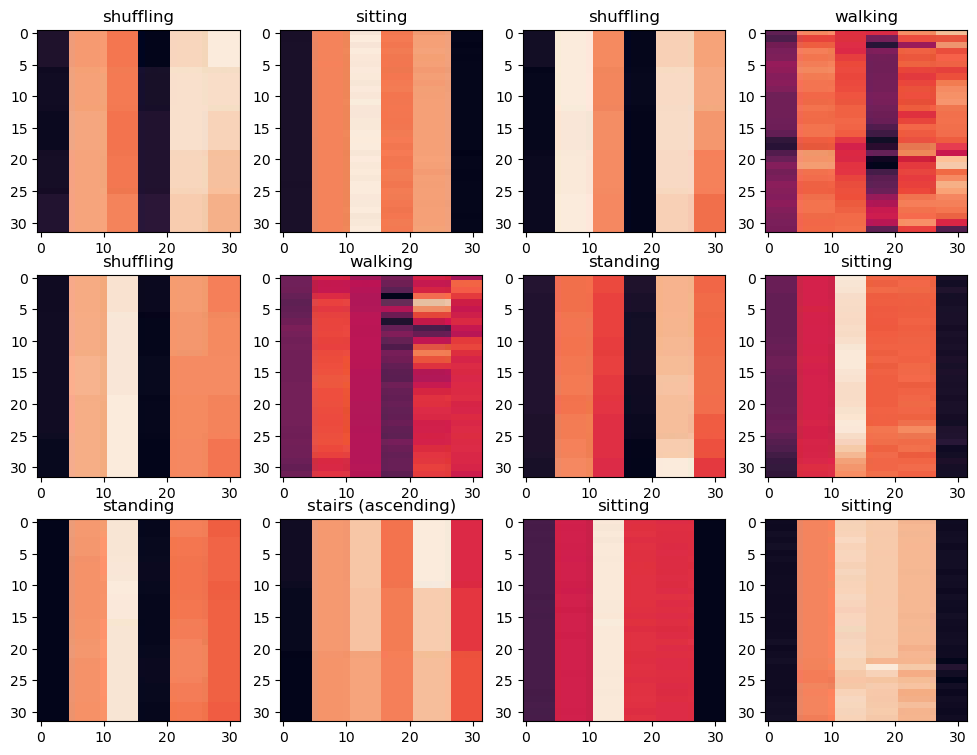

In [6]:
plt.figure(figsize=(12, 9))
for images, labels in train_generator.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(res_dict[np.argmax(labels[i], axis=-1)])

# Building a  CNN model

In [7]:
from tensorflow.keras.applications import ResNet50V2#DenseNet121#EfficientNetB3#DenseNet121#ResNet50V2

# Create base model
base_model = ResNet50V2(#EfficientNetB3(#DenseNet121(#ResNet50V2
    input_shape=(image_dimension, image_dimension, 3),
    include_top=False,  # Remove original classification layer
    weights=None,
    pooling='avg'  # Adds GlobalAveragePooling2D at output
)

# Freeze base model
base_model.trainable = True

# Build custom top layers
inp = base_model.input
x = base_model.output
x = tensor.Dense(128, activation='relu')(x)  # 'tensor' here refers to tf.keras.layers
x = tensor.Dropout(0.3)(x)
out = tensor.Dense(output_parameter, activation='softmax')(x)


## compile the model
Then, we can compile it with some parameters such as:

1.Optimizer:adam = RMSProp + Momentum.

Momentum = takes into account past gradient to have a better update.
RMSProp = exponentially weighted average of the squares of past gradients.

Adam is an adaptive deep neural network training optimizer that has been used in most cases.

2.Loss function: we use categorical crossentropy for classification, each images belongs to one class only.

3.Metrics:we use the 'categorical_accuracy' metrics.This calculates how often predictions match one-hot labels.

In [8]:
model = keras.Model(inputs = inp , outputs = out)
model.compile(optimizer = 'Adam',loss="categorical_crossentropy",metrics = ['categorical_accuracy'])
print(model.summary()) 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 18, 18, 64)   0           ['conv1_conv[0][0]']             
                                                                                              

## Train / fit the data to the model
Fit the model to the data from the train_generator.
The neural network will learn by itself the pattern in order to distinguish each category.

In [9]:
training=model.fit(train_generator,batch_size=8,epochs =35,verbose=1,validation_data=validation_generator,validation_steps=10)

Epoch 1/35
338/338 [==============================] - 23s 43ms/step - loss: 0.8411 - categorical_accuracy: 0.6698 - val_loss: 0.6801 - val_categorical_accuracy: 0.7219
Epoch 2/35
338/338 [==============================] - 14s 40ms/step - loss: 0.6852 - categorical_accuracy: 0.7258 - val_loss: 0.7391 - val_categorical_accuracy: 0.7094
Epoch 3/35
338/338 [==============================] - 14s 40ms/step - loss: 0.5975 - categorical_accuracy: 0.7660 - val_loss: 1.1181 - val_categorical_accuracy: 0.7469
Epoch 4/35
338/338 [==============================] - 14s 40ms/step - loss: 0.4240 - categorical_accuracy: 0.8378 - val_loss: 0.4233 - val_categorical_accuracy: 0.8313
Epoch 5/35
338/338 [==============================] - 14s 40ms/step - loss: 0.3243 - categorical_accuracy: 0.8861 - val_loss: 0.2860 - val_categorical_accuracy: 0.8781
Epoch 6/35
338/338 [==============================] - 14s 40ms/step - loss: 0.2439 - categorical_accuracy: 0.9249 - val_loss: 0.3254 - val_categorical_accuracy:

## Ploting accuracy score

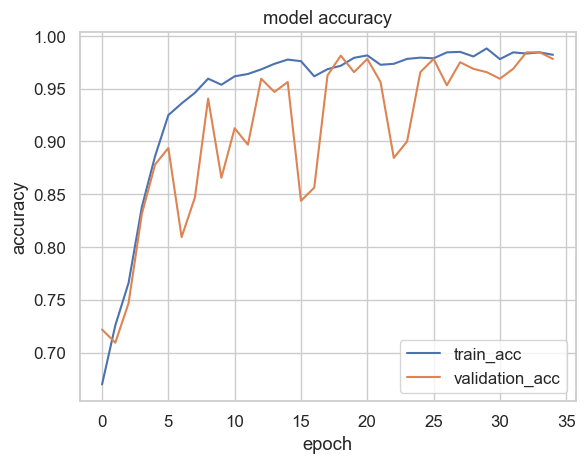

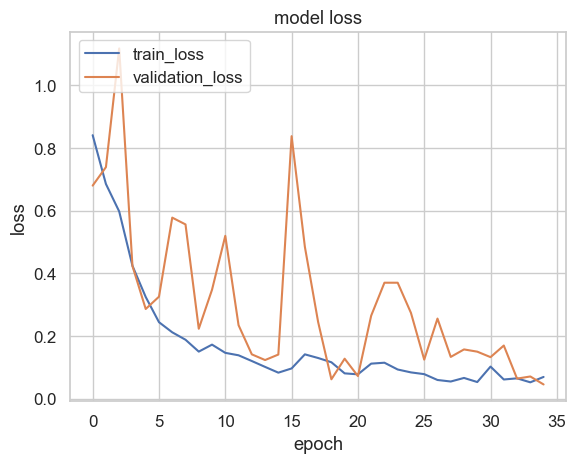

In [14]:
# Plot accuracy
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.plot(training.history['categorical_accuracy'])
plt.plot(training.history['val_categorical_accuracy'])
plt.legend(['train_acc', 'validation_acc'])
plt.show()

# Plot loss
plt.figure()
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.plot(training.history['loss'])
plt.plot(training.history['val_loss'])
plt.legend(['train_loss', 'validation_loss'], loc='upper left')
plt.show()

# prediction
Creating a custom function to predict accuracy and analyze probability.

73/73 [==============================] - 2s 12ms/step


C:\Users\Anindya\AppData\Local\Temp\ipykernel_13476\1433819172.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('RdYlBu', 10)


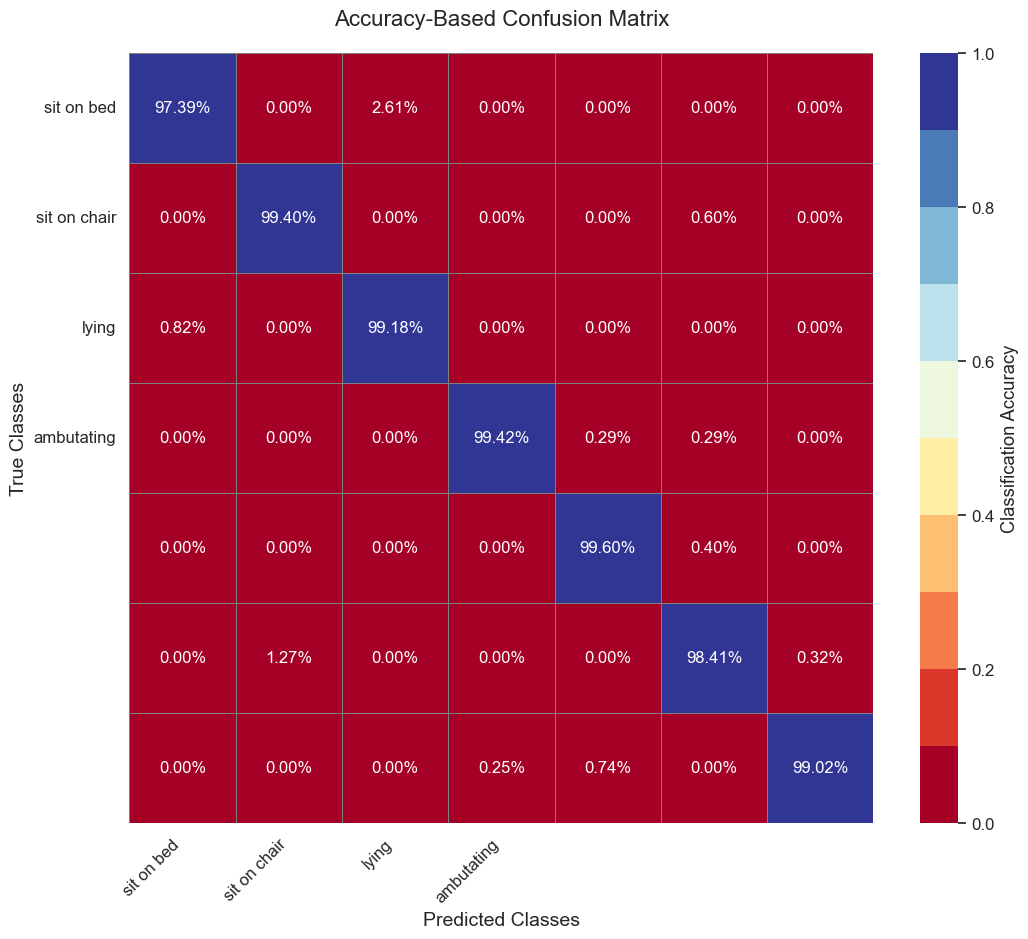

<Figure size 1800x800 with 0 Axes>

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, f1_score,precision_recall_curve

# First disable shuffling for evaluation

#class_names = ['walking','shuffling','stairs (ascending)','stairs (descending)','standing','sitting','lying']
class_names = ['sit on bed','sit on chair','lying','ambutating']

# Get all labels and images
y_true = []
y_images = []

for images, labels in test_generator:
    y_true.extend(labels.numpy())
    y_images.extend(images.numpy())

y_true = np.array(y_true)
y_images = np.array(y_images)

# Get predictions
y_pred = model.predict(y_images)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_true, axis=1)  # Convert from categorical

# Confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Convert to percentages

plt.figure(figsize=(12, 10))
sns.set(font_scale=1.1)  # Adjust label size
sns.set_style("whitegrid") 

# Create custom color palette
cmap = plt.cm.get_cmap('RdYlBu', 10)  
class_accuracy = cm.diagonal() / cm.sum(axis=1)
# Plot confusion matrix heatmap
ax = sns.heatmap(cm_normalized, annot=True, fmt=".2%", cmap=cmap,cbar_kws={'label': 'Classification Accuracy'},linewidths=0.5,linecolor='gray',annot_kws={'size': 12},vmin=0, vmax=1,xticklabels=class_names,yticklabels=class_names)

# Add decorations
plt.title("Accuracy-Based Confusion Matrix", fontsize=16, pad=20)
plt.xlabel('Predicted Classes', fontsize=14)
plt.ylabel('True Classes', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)


plt.figure(figsize=(18, 8))
sns.set_style("whitegrid")


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (4,) and arg 1 with shape (7,).

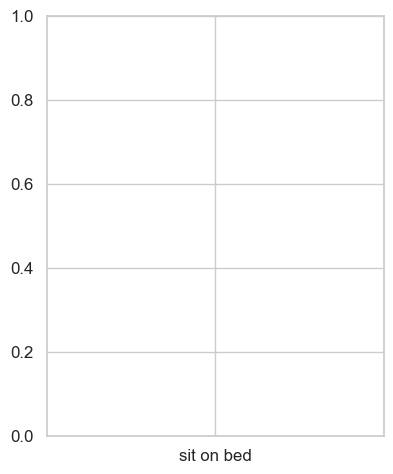

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import f1_score, precision_score, recall_score

# Calculate additional metrics
precision = precision_score(y_true_classes, y_pred_classes, average=None)
recall = recall_score(y_true_classes, y_pred_classes, average=None)
f1 = f1_score(y_true_classes, y_pred_classes, average=None)

# Create color palettes
accuracy_palette = sns.color_palette("Blues_d", n_colors=len(class_names))
precision_palette = sns.color_palette("Greens_d", n_colors=len(class_names))
recall_palette = sns.color_palette("Purples_d", n_colors=len(class_names))
f1_palette = sns.color_palette("YlOrRd", n_colors=len(class_names))

# Create a larger figure with longer graphs
plt.figure(figsize=(20, 12))

# Classification Accuracy Plot
plt.subplot(2, 4, 1)
bars = plt.bar(class_names, class_accuracy, 
             color=accuracy_palette,
             edgecolor='black', linewidth=1.5)

for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.0%}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 5),  # Increased vertical offset
                 textcoords="offset points",
                 ha='center', va='bottom',
                 fontsize=14, color='darkblue') 

plt.title("Classification Accuracy by Activity", fontsize=16, pad=20)  
plt.ylim(0, 1.15)
plt.ylabel('Accuracy Score', fontsize=16) 
plt.xticks(rotation=45, ha='right', fontsize=14)  
plt.yticks(np.arange(0, 1.1, 0.2), fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Precision Plot
plt.subplot(2, 4, 2)
precision_bars = plt.bar(class_names, precision,
                       color=precision_palette,
                       edgecolor='black', linewidth=1.5)

for bar in precision_bars:
    height = bar.get_height()
    plt.annotate(f'{height:.2f}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 5), 
                 textcoords="offset points",
                 ha='center', va='bottom',
                 fontsize=14, color='darkgreen')  

plt.title("Precision Scores by Activity", fontsize=16, pad=20) 
plt.ylim(0, 1.15)
plt.ylabel('Precision Score', fontsize=16) 
plt.xticks(rotation=45, ha='right', fontsize=14) 
plt.yticks(np.arange(0, 1.1, 0.2), fontsize=14)  
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Recall Plot
plt.subplot(2, 4, 3)
recall_bars = plt.bar(class_names, recall,
                    color=recall_palette,
                    edgecolor='black', linewidth=1.5)

for bar in recall_bars:
    height = bar.get_height()
    plt.annotate(f'{height:.2f}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 5),  # Increased vertical offset
                 textcoords="offset points",
                 ha='center', va='bottom',
                 fontsize=14, color='purple')  

plt.title("Recall Scores by Activity", fontsize=16, pad=20)  
plt.ylim(0, 1.15)
plt.ylabel('Recall Score', fontsize=16)  
plt.xticks(rotation=45, ha='right', fontsize=14)  
plt.yticks(np.arange(0, 1.1, 0.2), fontsize=14)  
plt.grid(axis='y', linestyle='--', alpha=0.7)

# F1 Scores Plot
plt.subplot(2, 4, 4)
f1_bars = plt.bar(class_names, f1,
                color=f1_palette,
                edgecolor='black', linewidth=1.5)

for bar in f1_bars:
    height = bar.get_height()
    plt.annotate(f'{height:.2f}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 5),  # Increased vertical offset
                 textcoords="offset points",
                 ha='center', va='bottom',
                 fontsize=14, color='darkred') 

plt.title("F1 Scores by Activity", fontsize=16, pad=20) 
plt.ylim(0, 1.15)
plt.ylabel('F1 Score', fontsize=16)  
plt.xticks(rotation=45, ha='right', fontsize=14)  
plt.yticks(np.arange(0, 1.1, 0.2), fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)


plt.tight_layout()
plt.subplots_adjust(top=0.92, hspace=0.5, wspace=0.4)  # More spacing between subplots
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score


y_true = []
y_pred = []

for images, labels in test_generator:
    # Get model predictions for the batch.
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print(classification_report(y_true, y_pred, target_names=test_generator.class_names))




In [ ]:
#import numpy
#print(numpy.__version__);print(numpy.__file__);
#import cv2

In [ ]:
#conda install Pillow opencv matplotlib numpy=1.26